## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">1. Kütüphaneleri İçe Aktar</div>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split,RandomizedSearchCV,cross_val_score,GridSearchCV,cross_validate
import sklearn.metrics as metrics 
import matplotlib.cm as cm
import scipy.stats as stats             # İstatistiksel testler, dağılımlar, olasılık araçları
import warnings

# algorithms
!pip install xgboost
!pip install lightgbm
!pip install catboost
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
# data preprocessing
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier     #2
from sklearn.svm import SVC

from catboost import CatBoostClassifier       #3
from xgboost import XGBClassifier
#from lightgbm import LGBMClassifier


warnings.filterwarnings('ignore')       # Tüm uyarıları bastırır (genelde geçici kullanım önerilir)
warnings.filterwarnings(
    "ignore",
    message="A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy"
)                                       # Belirli uyarı mesajını hedefli olarak gizler

# metrics
from sklearn.metrics import mean_squared_error, r2_score ,explained_variance_score


from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report


## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">2. Veri Yükleme</div>

In [3]:
import xgboost as xgb
print(xgb.__version__)
import lightgbm as lgb
print(lgb.__version__)
import catboost
print(catboost.__version__)

3.1.3
4.6.0
1.2.8


In [5]:
!pip install yellowbrick

In [6]:
df_ = pd.read_csv("gamingbehaviordb.csv", encoding="utf-8")
df = df_.copy()

In [7]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 100000)

df.head(5)

,PlayerID,Age,Gender,Location,GameGenre,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel
0,9000,43,Male,Other,Strategy,0,Medium,6,108,79,25,Medium
1,9001,29,Female,USA,Strategy,0,Medium,5,144,11,10,Medium
2,9002,22,Female,USA,Sports,0,Easy,16,142,35,41,High
3,9003,35,Male,USA,Action,1,Easy,9,85,57,47,Medium
4,9004,33,Male,Europe,Action,0,Medium,2,131,95,37,Medium


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   PlayerID                   40034 non-null  int64 
 1   Age                        40034 non-null  int64 
 2   Gender                     40034 non-null  object
 3   Location                   40034 non-null  object
 4   GameGenre                  40034 non-null  object
 5   InGamePurchases            40034 non-null  int64 
 6   GameDifficulty             40034 non-null  object
 7   SessionsPerWeek            40034 non-null  int64 
 8   AvgSessionDurationMinutes  40034 non-null  int64 
 9   PlayerLevel                40034 non-null  int64 
 10  AchievementsUnlocked       40034 non-null  int64 
 11  EngagementLevel            40034 non-null  object
dtypes: int64(7), object(5)
memory usage: 3.7+ MB


In [13]:
df.describe([0.05,0.1,0.5,0.75,0.90,0.95,0.99]).T

,count,mean,std,min,5%,10%,50%,75%,90%,95%,99%,max
PlayerID,40034.000,29016.500,11556.965,9000.000,11001.650,13003.300,29016.500,39024.750,45029.700,47031.350,48632.670,49033.000
Age,40034.000,31.993,10.043,15.000,16.000,18.000,32.000,41.000,46.000,48.000,49.000,49.000
InGamePurchases,40034.000,0.201,0.401,0.000,0.000,0.000,0.000,0.000,1.000,1.000,1.000,1.000
SessionsPerWeek,40034.000,9.472,5.764,0.000,1.000,2.000,9.000,14.000,18.000,19.000,19.000,19.000
AvgSessionDurationMinutes,40034.000,94.792,49.011,10.000,18.000,27.000,95.000,137.000,162.000,171.000,178.000,179.000
PlayerLevel,40034.000,49.656,28.588,1.000,5.000,10.000,49.000,74.000,89.000,95.000,99.000,99.000
AchievementsUnlocked,40034.000,24.526,14.431,0.000,2.000,4.000,25.000,37.000,45.000,47.000,49.000,49.000


1. Hedef Değişken İpucu: InGamePurchases (Satın Alma)
Mean (Ortalama) = 0.201: Bu çok kritik! Oyuncularının sadece %20'si harcama yapmış. Hedef değişken kullanmamalıyız

Yorum: Eğer makine öğrenmesinde "kim satın alır?" sorusunu tahmin edeilirse, elimizde dengesiz (imbalanced) bir veri seti var demektir. %80 hayır, %20 evet. Bu, model kurarken dikkat etmemiz gereken bir detay.

2. Demografik Yapı: Age (Yaş)
Min: 15 / Max: 49: Veri setinde çocuklardan ziyade, genç ve orta yaşlı yetişkinler var.

Mean (32) ve Median (32): Ortalama ve medyan birbirine çok yakın. Bu, yaş dağılımının oldukça simetrik ve düzenli olduğunu gösterir. "Normal dağılıma" yakın bir kitlemiz var.

3. Oyun Alışkanlıkları: SessionsPerWeek ve Duration
SessionsPerWeek (Haftalık Seans): Ortalamada haftada 9.5 kez oyuna giriliyor. Bazı oyuncular haftada 19 kez giriyor (günde neredeyse 3 kez!), bazıları ise 0 (yani o hafta hiç girmemiş).

AvgSessionDurationMinutes: Bir oturuşta ortalama 95 dakika (1.5 saat) harcanıyor. En kısa süre 10 dk, en uzun süre 179 dk (3 saat).

***Yorum: Oyuncular oyuna girdiklerinde ciddi vakit ayırıyorlar. Bu, "bağlılık" (engagement) potansiyelinin yüksek olduğunu gösterir.****

4. Oyun İlerlemesi: PlayerLevel ve AchievementsUnlocked
PlayerLevel: 1'den 99'a kadar her seviyeden oyuncu var. Ortalamanın 49 olması, veri setinin yeni başlayanlar ve uzmanlar arasında tam dengeli dağıldığını kanıtlıyor.

AchievementsUnlocked: Başarılar da aynı şekilde 0 ile 49 arasında çok düzenli dağılmış.

## Eklenecek Veriler

In [18]:
# Haftalık Toplam Oyun Süresi (Dakika)
df['TotalWeeklyTime'] = df['SessionsPerWeek'] * df['AvgSessionDurationMinutes']

# Başarı Oranı (Seviye başına kaç başarı kazanmış?)
df['AchievementRate'] = df['AchievementsUnlocked'] / (df['PlayerLevel'] + 1)

# Yaş Grupları
bins = [0, 18, 25, 35, 50]
labels = ['Genç', 'Genç Yetişkin', 'Yetişkin', 'Olgun']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels)

print("Yeni sütunlar başarıyla eklendi!")
df.head(10)

Yeni sütunlar başarıyla eklendi!


,PlayerID,Age,Gender,Location,GameGenre,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,TotalWeeklyTime,AchievementRate,AgeGroup
0,9000,43,Male,Other,Strategy,0,Medium,6,108,79,25,Medium,648,0.312,Olgun
1,9001,29,Female,USA,Strategy,0,Medium,5,144,11,10,Medium,720,0.833,Yetişkin
2,9002,22,Female,USA,Sports,0,Easy,16,142,35,41,High,2272,1.139,Genç Yetişkin
3,9003,35,Male,USA,Action,1,Easy,9,85,57,47,Medium,765,0.810,Yetişkin
4,9004,33,Male,Europe,Action,0,Medium,2,131,95,37,Medium,262,0.385,Yetişkin
5,9005,37,Male,Europe,RPG,0,Easy,2,81,74,22,Low,162,0.293,Olgun
6,9006,25,Male,USA,Action,0,Hard,1,50,13,2,Low,50,0.143,Genç Yetişkin
7,9007,25,Female,Asia,RPG,0,Medium,10,48,27,23,Medium,480,0.821,Genç Yetişkin
8,9008,38,Female,Europe,Simulation,0,Easy,5,101,23,41,Medium,505,1.708,Olgun
9,9009,38,Female,Other,Sports,0,Easy,13,95,99,36,High,1235,0.360,Olgun


"""Senaryolaştırma (Storytelling)"""

"Biz 40.000 oyuncuyu inceledik. Gördük ki; RPG ve Strategy türünde 'Olgun' yaş grubu daha fazla vakit geçirirken, Action oyunlarında 'Genç' kitle domine ediyor. Ayrıca, AchievementRate (Başarı Oranı) yüksek olan oyuncuların harcama yapma eğilimi %X daha fazla. Bu yüzden başarı kazanan oyunculara özel teklifler sunmalıyız."

In [21]:
if 'AgeGroup' in df.columns:
    df.drop('AgeGroup', axis=1, inplace=True)

# 2. "Generation" (Kuşaklar) sütununu ekleyelim
conditions = [
    (df['Age'] < 25),
    (df['Age'] >= 25) & (df['Age'] < 41),
    (df['Age'] >= 41) & (df['Age'] < 57),
    (df['Age'] >= 57)
]
choices = ['Gen Z', 'Millennials', 'Gen X', 'Baby Boomers']

df['Generation'] = np.select(conditions, choices, default='Null')

# 3. Kontrol edelim
print(df['Generation'].value_counts())

Generation
Millennials    18488
Gen Z          11368
Gen X          10178
Name: count, dtype: int64


## <div style="border-radius: 10px; border: 2px solid #ffd700; padding: 15px; background-color: #333; font-size: 120%; text-align: center; color: #ffd700; font-weight: bold;">3. Keşifsel Veri Analizi</div>

In [24]:
duplicated = df.duplicated().sum()
print(duplicated)

0


2 | Check null and missing value

In [27]:
missing_values = df.isnull().sum()
total_missing_values = (missing_values).sum()
total_cells = np.prod(df.shape)
percent_missing = (total_missing_values/total_cells) * 100
print("Percent of data that is missing :", percent_missing)
print(missing_values)

Percent of data that is missing : 0.0
PlayerID                     0
Age                          0
Gender                       0
Location                     0
GameGenre                    0
InGamePurchases              0
GameDifficulty               0
SessionsPerWeek              0
AvgSessionDurationMinutes    0
PlayerLevel                  0
AchievementsUnlocked         0
EngagementLevel              0
TotalWeeklyTime              0
AchievementRate              0
Generation                   0
dtype: int64


# 1. Bölüm: Tutarsızlık (Anomaly) Analizi
Bu kodlarla "hileci" veya "pasif" oyuncuları yakalayacağız.

In [30]:
# 1. Hileci/Hatalı Veri Kontrolü: Yüksek Seviye ama Çok Düşük Başarı
cheaters = df[(df['PlayerLevel'] > 80) & (df['AchievementsUnlocked'] < 5)]
print(f"Yüksek Seviye (>80) olup Başarısı çok düşük (<5) olan kişi sayısı: {len(cheaters)}")

# 2. Pasif/Churn Kontrolü: Hiç oynamıyor ama seviyesi yüksek
passive_players = df[(df['SessionsPerWeek'] == 0) & (df['PlayerLevel'] > 10)]
print(f"Haftalık seansı 0 olup Seviyesi 10'dan büyük olan kişi sayısı: {len(passive_players)}")



Yüksek Seviye (>80) olup Başarısı çok düşük (<5) olan kişi sayısı: 781
Haftalık seansı 0 olup Seviyesi 10'dan büyük olan kişi sayısı: 1760


1- Analiz: Bu normalde imkansıza yakındır. Seviye atlamak için görev yapman gerekir. Bu kitle "Pay-to-Win" (para verip seviye atlayanlar) veya veri hatası olabilir.

2-Analiz: Bir insan hiç oynamadan nasıl level 10+ olur? Bu kişiler büyük ihtimalle "Churn" (oyunu terk etmiş) oyuncular. Eskiden oynamış, seviye kasmış ama şu an haftalık aktifliği sıfıra inmiş. Bu grup "Geri Kazanım" stratejileri için çok değerli.

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40034 entries, 0 to 40033
Data columns (total 15 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PlayerID                   40034 non-null  int64  
 1   Age                        40034 non-null  int64  
 2   Gender                     40034 non-null  object 
 3   Location                   40034 non-null  object 
 4   GameGenre                  40034 non-null  object 
 5   InGamePurchases            40034 non-null  int64  
 6   GameDifficulty             40034 non-null  object 
 7   SessionsPerWeek            40034 non-null  int64  
 8   AvgSessionDurationMinutes  40034 non-null  int64  
 9   PlayerLevel                40034 non-null  int64  
 10  AchievementsUnlocked       40034 non-null  int64  
 11  EngagementLevel            40034 non-null  object 
 12  TotalWeeklyTime            40034 non-null  int64  
 13  AchievementRate            40034 non-null  flo

In [36]:
df.head()

,PlayerID,Age,Gender,Location,GameGenre,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,TotalWeeklyTime,AchievementRate,Generation
0,9000,43,Male,Other,Strategy,0,Medium,6,108,79,25,Medium,648,0.312,Gen X
1,9001,29,Female,USA,Strategy,0,Medium,5,144,11,10,Medium,720,0.833,Millennials
2,9002,22,Female,USA,Sports,0,Easy,16,142,35,41,High,2272,1.139,Gen Z
3,9003,35,Male,USA,Action,1,Easy,9,85,57,47,Medium,765,0.810,Millennials
4,9004,33,Male,Europe,Action,0,Medium,2,131,95,37,Medium,262,0.385,Millennials


# 2. Değişkenlerin Ayrıştırılması


In [41]:
cat_cols = [
    col for col in df.columns
    if df[col].dtypes == "O" and col not in ["EngagementLevel"]
]

num_cols = [
    col for col in df.columns
    if df[col].dtypes != "O"
    and col not in ["PlayerID", "InGamePurchases"]
]

binary_cols = [
    col for col in df.columns
    if df[col].nunique() == 2 and col not in ["EngagementLevel"]
]



In [43]:
print(cat_cols)
num_cols


['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'Generation']


['Age',
 'SessionsPerWeek',
 'AvgSessionDurationMinutes',
 'PlayerLevel',
 'AchievementsUnlocked',
 'TotalWeeklyTime',
 'AchievementRate']

# Numeric Columns

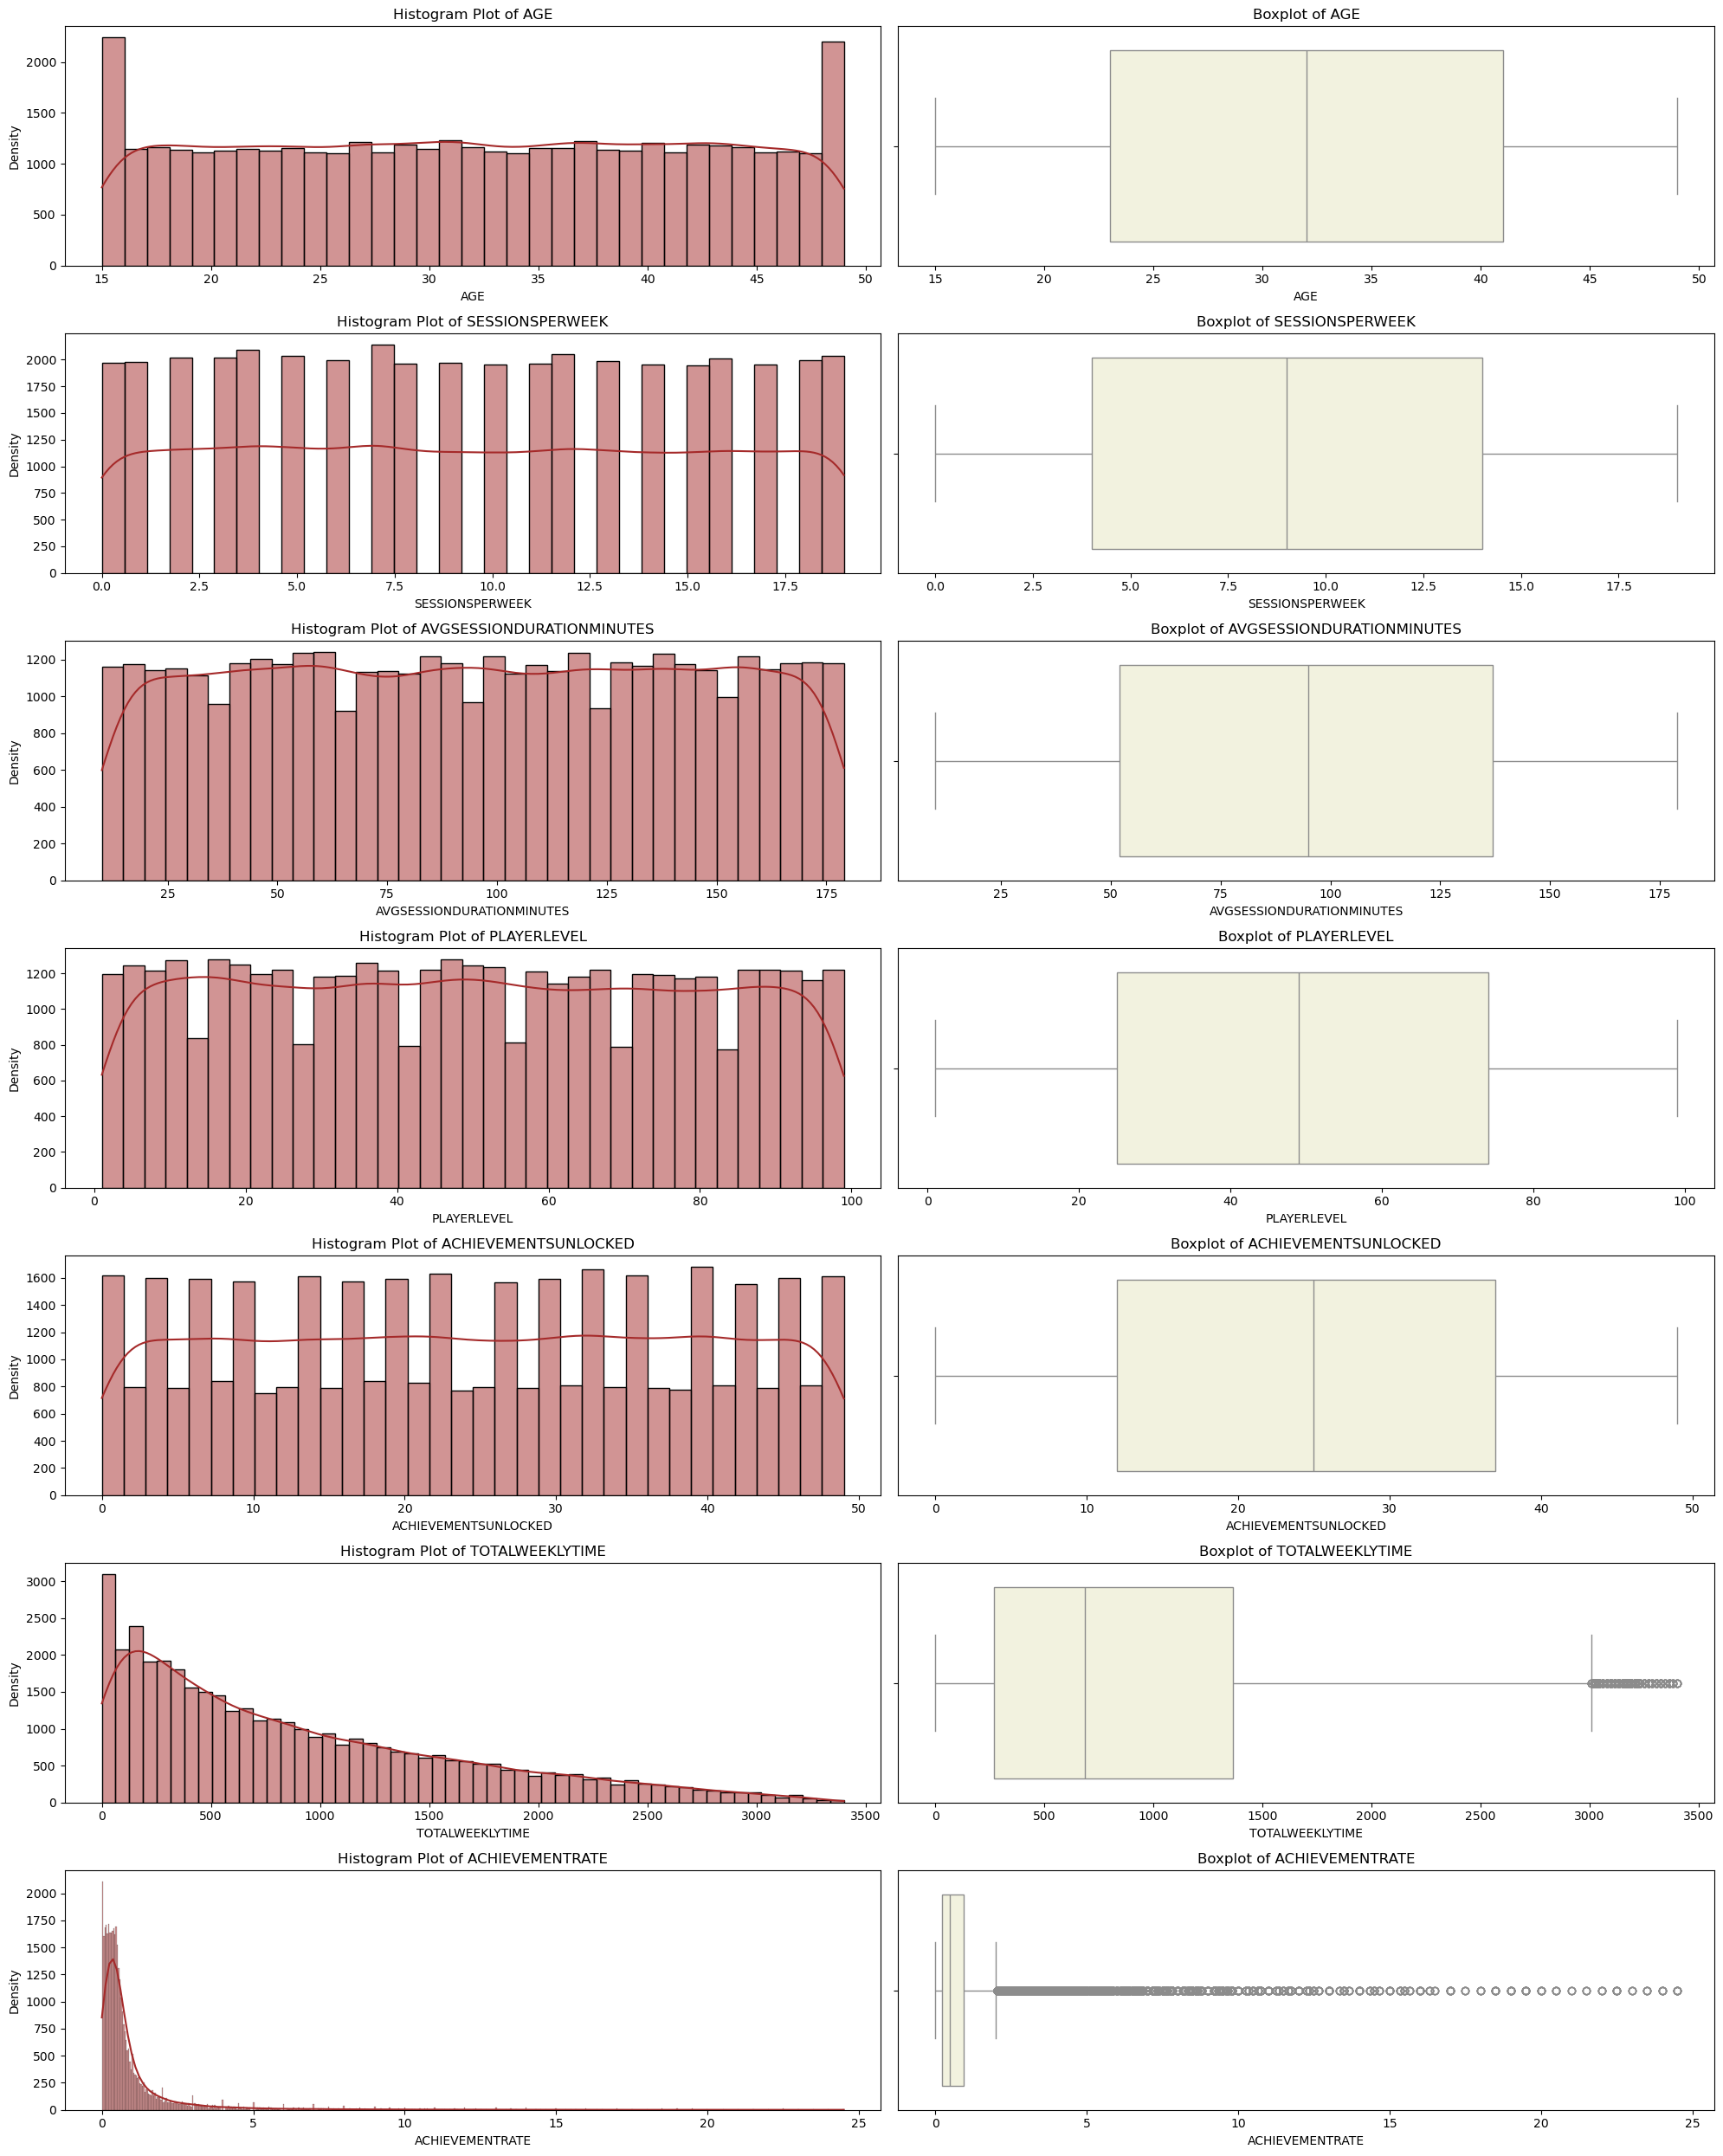

In [47]:
plt.figure(figsize=(20, 25))
for i, col in enumerate(num_cols):
    # Distribution
    plt.subplot(7, 2, 2*i+1)   
    sns.histplot(df[col], kde=True, color='brown')
    plt.xlabel(f"{col.upper()}")
    plt.ylabel('Density')
    plt.title(f"Histogram Plot of {col.upper()}")
    plt.tight_layout()
    
    # Boxplot
    plt.subplot(7, 2, 2*i+2)   
    sns.boxplot(df[col], orient='h', color='beige')
    plt.xlabel(f"{col.upper()}")
    plt.title(f"Boxplot of {col.upper()}")
plt.show()


“Feature engineering aşamasında türetilen TotalWeeklyTime değişkeni, oyuncu davranışını yansıttığı için aykırı değer olarak değerlendirilmemiştir. AchievementRate değişkeninde ise matematiksel oranlamadan kaynaklı uç değerler oluştuğu gözlemlenmiş ve bu değerler silinmek yerine üst sınırdan baskılanarak modele dahil edilecektir.”

## "Veriyi Anlama" Sonucu ve Aksiyon Kararı:
Şu an verinin karakterini tam olarak çözdük. EDA'ya geçerken şu iki aksiyonu alabiliriz:

## Churn Analizi: "Haftalık seansı 0 ama seviyesi yüksek" olanları "Pasif Oyuncu" olarak etiketleyip analiz edelim.

## Hile/Hata Temizliği: "Seviyesi 90 ama başarısı 0" olan uç örnekleri (outlier) temizlemek modelin başarısını artıracaktır.

"Analizimiz sırasında veride iki kritik grup saptadık. 1.760 kişilik bir grup yüksek seviyede olmasına rağmen artık oyuna girmiyor (Churn Risk). Bu grup için 'Seni özledik' temalı e-postalar ve geri dönüş bonusları planladık. 781 kişilik bir grupta ise seviye-başarı tutarsızlığı gördük (Anomaly Suspect), bu hesapları anti-cheat (hile koruma) sistemimize inceleme için yönlendirdik."

In [51]:
df.head(5)

,PlayerID,Age,Gender,Location,GameGenre,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,TotalWeeklyTime,AchievementRate,Generation
0,9000,43,Male,Other,Strategy,0,Medium,6,108,79,25,Medium,648,0.312,Gen X
1,9001,29,Female,USA,Strategy,0,Medium,5,144,11,10,Medium,720,0.833,Millennials
2,9002,22,Female,USA,Sports,0,Easy,16,142,35,41,High,2272,1.139,Gen Z
3,9003,35,Male,USA,Action,1,Easy,9,85,57,47,Medium,765,0.810,Millennials
4,9004,33,Male,Europe,Action,0,Medium,2,131,95,37,Medium,262,0.385,Millennials


# Keşifçi Veri Analizi - Exploratory Data Analysis (EDA)

## 2. Kategorik Değişken Analizi

In [54]:
cat_cols

['Gender', 'Location', 'GameGenre', 'GameDifficulty', 'Generation']

        Gender  Ratio
Gender               
Male     23959 59.847
Female   16075 40.153
##########################################


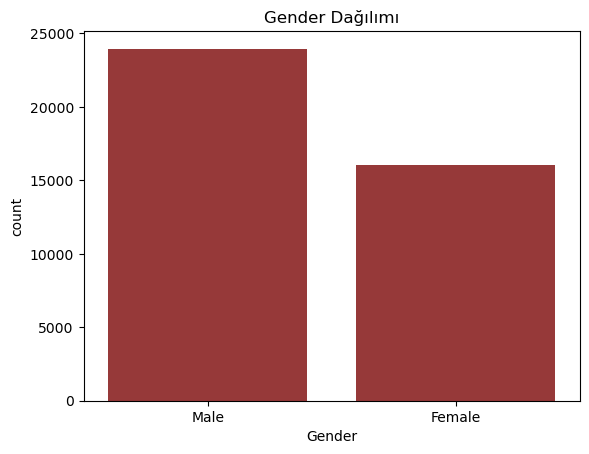

          Location  Ratio
Location                 
USA          16000 39.966
Europe       12004 29.985
Asia          8095 20.220
Other         3935  9.829
##########################################


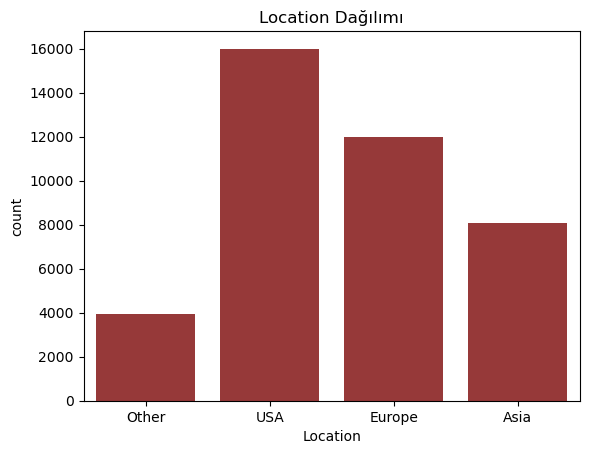

            GameGenre  Ratio
GameGenre                   
Sports           8048 20.103
Action           8039 20.080
Strategy         8012 20.013
Simulation       7983 19.941
RPG              7952 19.863
##########################################


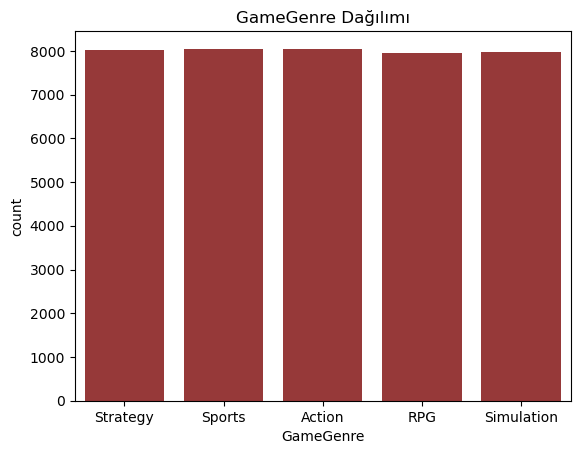

                GameDifficulty  Ratio
GameDifficulty                       
Easy                     20015 49.995
Medium                   12011 30.002
Hard                      8008 20.003
##########################################


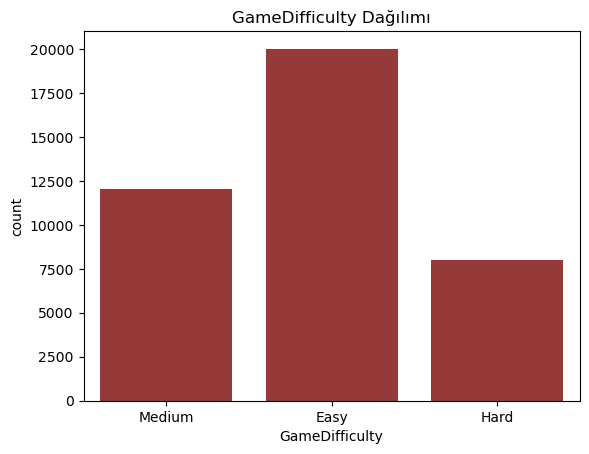

             Generation  Ratio
Generation                    
Millennials       18488 46.181
Gen Z             11368 28.396
Gen X             10178 25.423
##########################################


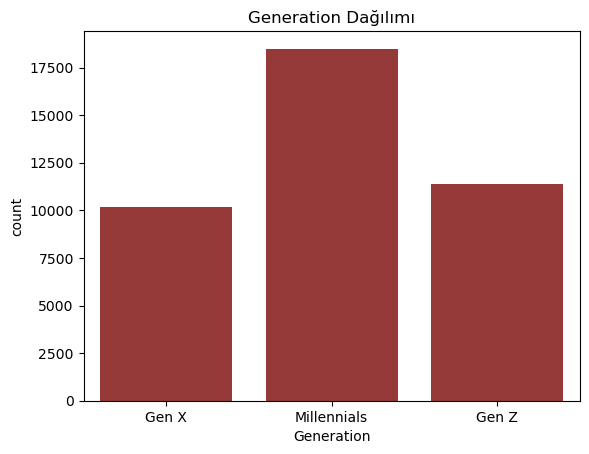

In [55]:

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
    print("##########################################")
    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe, color='brown')
        plt.title(f"{col_name} Dağılımı")
        plt.show()

for col in cat_cols:
    cat_summary(df, col, plot=True)

In [56]:
num_cols

['Age',
 'SessionsPerWeek',
 'AvgSessionDurationMinutes',
 'PlayerLevel',
 'AchievementsUnlocked',
 'TotalWeeklyTime',
 'AchievementRate']

## 3. Sayısal Değişken Analizi

count   40034.000
mean       31.993
std        10.043
min        15.000
5%         16.000
10%        18.000
20%        22.000
30%        25.000
40%        29.000
50%        32.000
60%        36.000
70%        39.000
80%        42.000
90%        46.000
95%        48.000
99%        49.000
max        49.000
Name: Age, dtype: float64


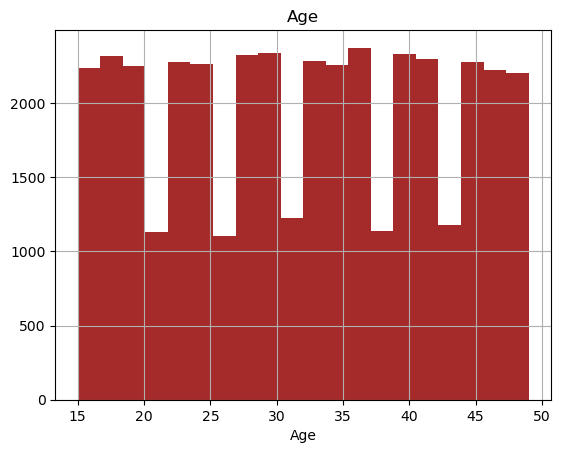

count   40034.000
mean        9.472
std         5.764
min         0.000
5%          1.000
10%         2.000
20%         4.000
30%         5.000
40%         7.000
50%         9.000
60%        11.000
70%        13.000
80%        15.000
90%        18.000
95%        19.000
99%        19.000
max        19.000
Name: SessionsPerWeek, dtype: float64


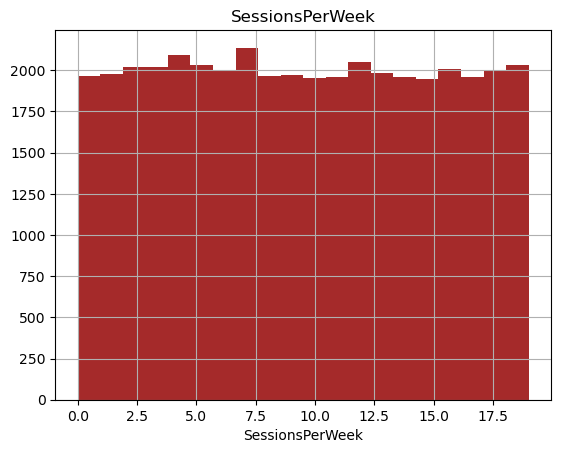

count   40034.000
mean       94.792
std        49.011
min        10.000
5%         18.000
10%        27.000
20%        44.000
30%        61.000
40%        78.000
50%        95.000
60%       112.000
70%       129.000
80%       146.000
90%       162.000
95%       171.000
99%       178.000
max       179.000
Name: AvgSessionDurationMinutes, dtype: float64


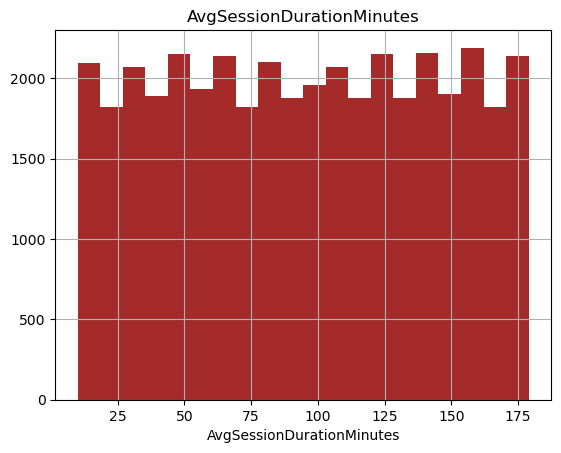

count   40034.000
mean       49.656
std        28.588
min         1.000
5%          5.000
10%        10.000
20%        20.000
30%        30.000
40%        40.000
50%        49.000
60%        59.000
70%        69.000
80%        79.000
90%        89.000
95%        95.000
99%        99.000
max        99.000
Name: PlayerLevel, dtype: float64


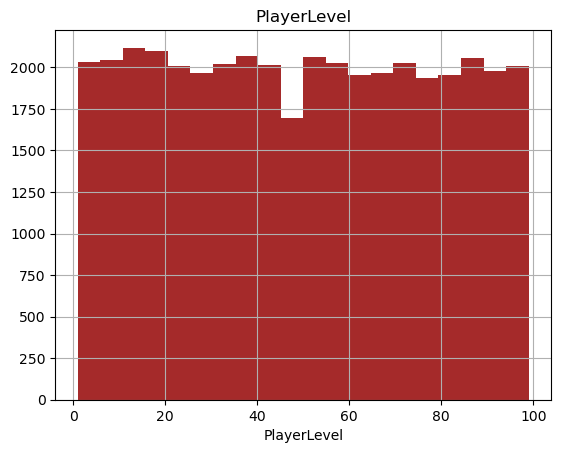

count   40034.000
mean       24.526
std        14.431
min         0.000
5%          2.000
10%         4.000
20%         9.000
30%        15.000
40%        20.000
50%        25.000
60%        30.000
70%        35.000
80%        40.000
90%        45.000
95%        47.000
99%        49.000
max        49.000
Name: AchievementsUnlocked, dtype: float64


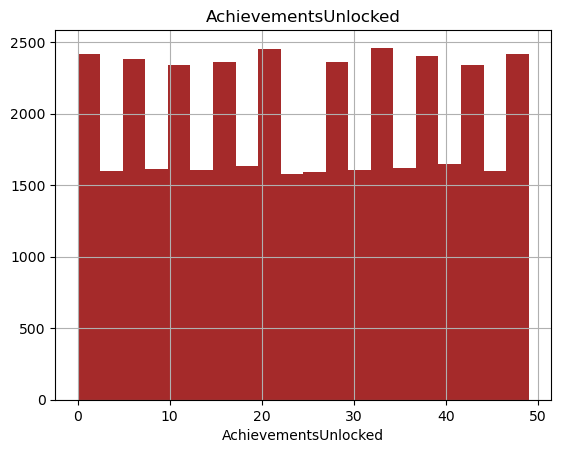

count   40034.000
mean      897.676
std       771.280
min         0.000
5%         12.000
10%        92.000
20%       204.000
30%       336.000
40%       492.000
50%       684.000
60%       910.000
70%      1196.100
80%      1560.000
90%      2080.000
95%      2470.000
99%      3024.000
max      3401.000
Name: TotalWeeklyTime, dtype: float64


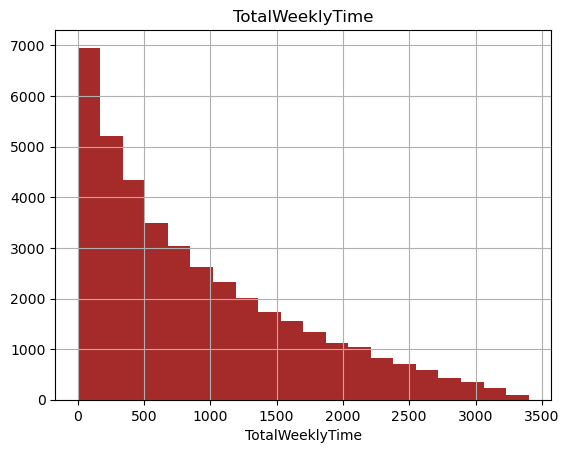

count   40034.000
mean        1.037
std         2.004
min         0.000
5%          0.039
10%         0.091
20%         0.188
30%         0.286
40%         0.387
50%         0.487
60%         0.606
70%         0.793
80%         1.167
90%         2.180
95%         3.833
99%        11.000
max        24.500
Name: AchievementRate, dtype: float64


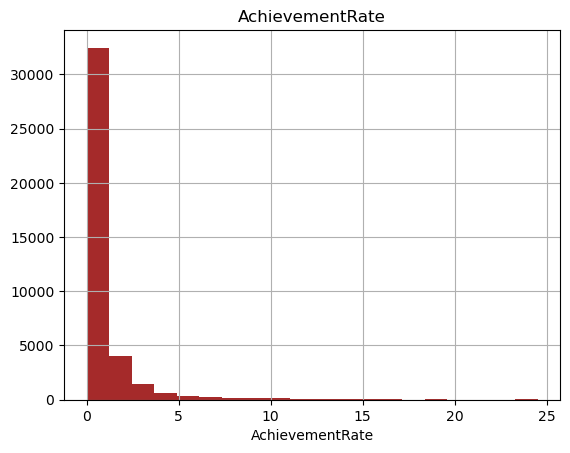

In [58]:
def num_summary(dataframe, numerical_col, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20,  color='brown')
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df, col, plot=True)

# Catefory Columns

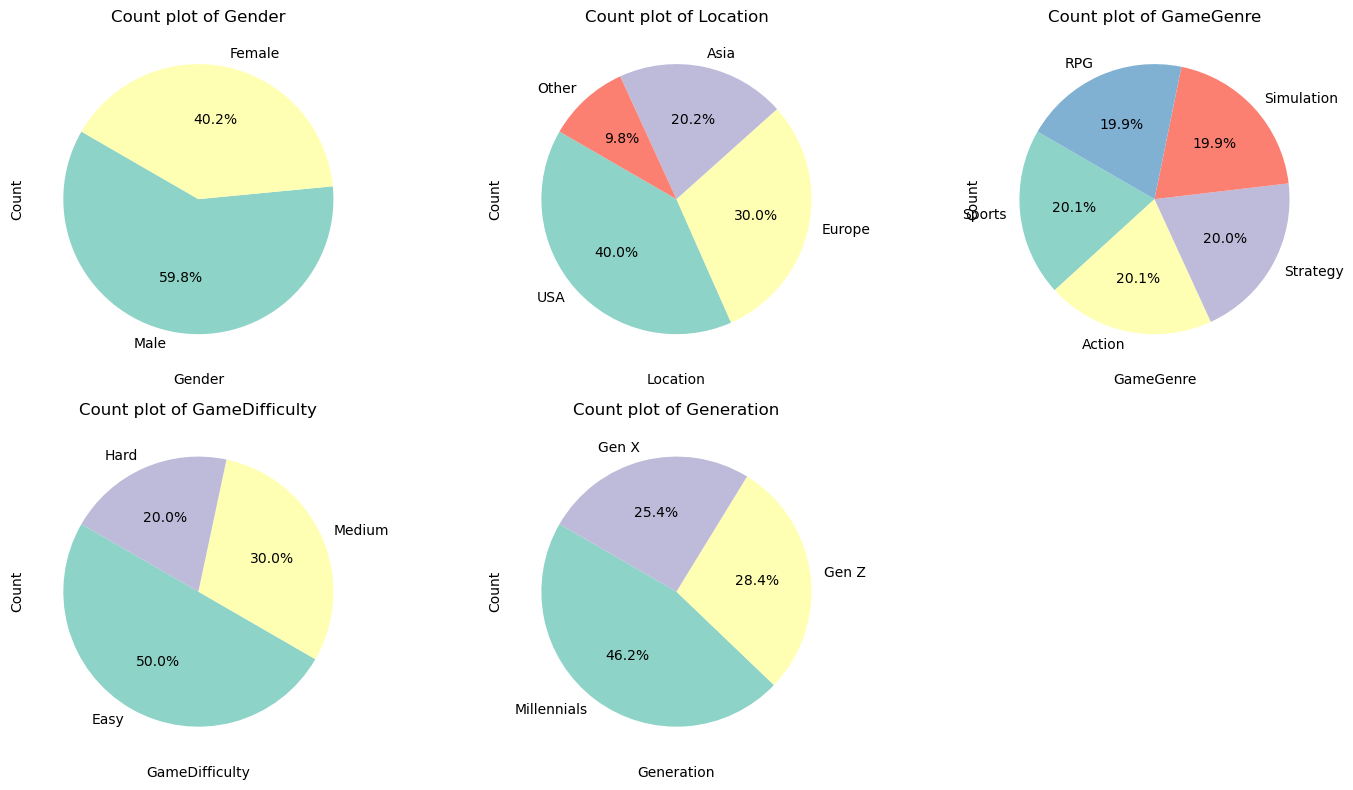

In [60]:
colors=cm.Set3(range(7))
plt.figure(figsize=(15,8))
for i,col in enumerate(cat_cols):
    plt.subplot(2,3,i+1)
    plt.pie(df[col].value_counts(),labels=df[col].value_counts().index,autopct='%1.1f%%', startangle=150, colors=colors)
    plt.title(f"Count plot of {col}")
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
plt.show()

Analiz: Yaş dağılımının simetrik  ve seans sürelerinin 100 dakika civarında yoğunlaştışmıştır

## 4. Hedef Değişken Sayısal Değişkenler ile Analizi (Target Analysis)

In [64]:
# Hedef değişkenin (EngagementLevel) sayısal değişkenlerle ilişkisi
def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

print("--- EngagementLevel'a Göre Sayısal Ortalamalar ---")
for col in num_cols:
    target_summary_with_num(df, "EngagementLevel", col)

--- EngagementLevel'a Göre Sayısal Ortalamalar ---
                   Age
EngagementLevel       
High            31.920
Low             31.897
Medium          32.082


                 SessionsPerWeek
EngagementLevel                 
High                      14.255
Low                        4.531
Medium                     9.553


                 AvgSessionDurationMinutes
EngagementLevel                           
High                               131.922
Low                                 66.882
Medium                              89.856


                 PlayerLevel
EngagementLevel             
High                  50.824
Low                   46.101
Medium                50.926


                 AchievementsUnlocked
EngagementLevel                      
High                           25.096
Low                            22.662
Medium                         25.216


                 TotalWeeklyTime
EngagementLevel                 
High                    1880.275
Low       

### Numerical & EngagamentLevel

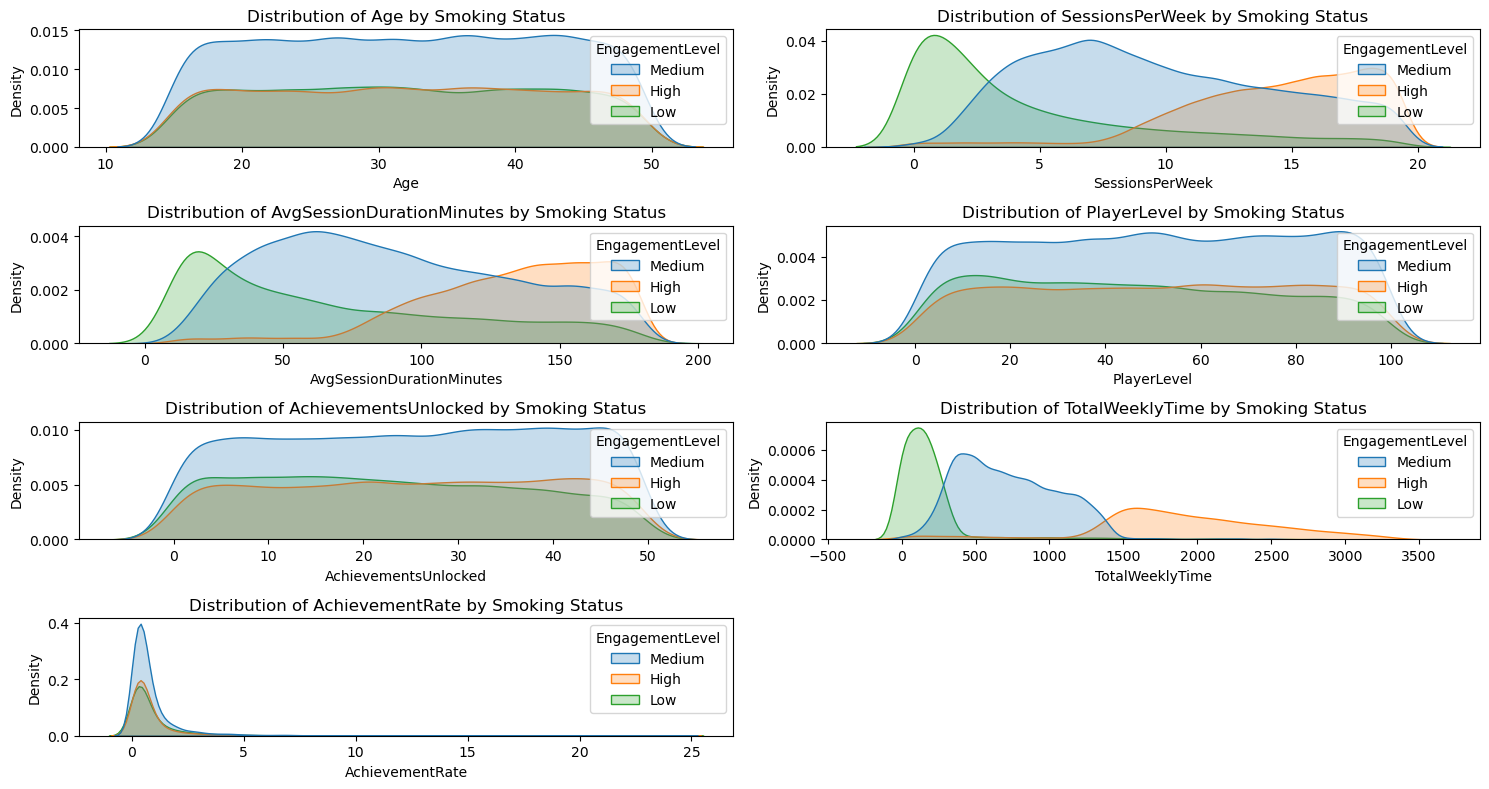

In [69]:
plt.figure(figsize=(15,8))
for i,col in enumerate(num_cols):
    plt.subplot(4,2,i+1)
    sns.kdeplot(x=df[col],hue=df['EngagementLevel'],fill=True)
    plt.title(f'Distribution of {col} by Smoking Status')
    plt.tight_layout()
plt.show()

## 5. Korelasyon Analizi

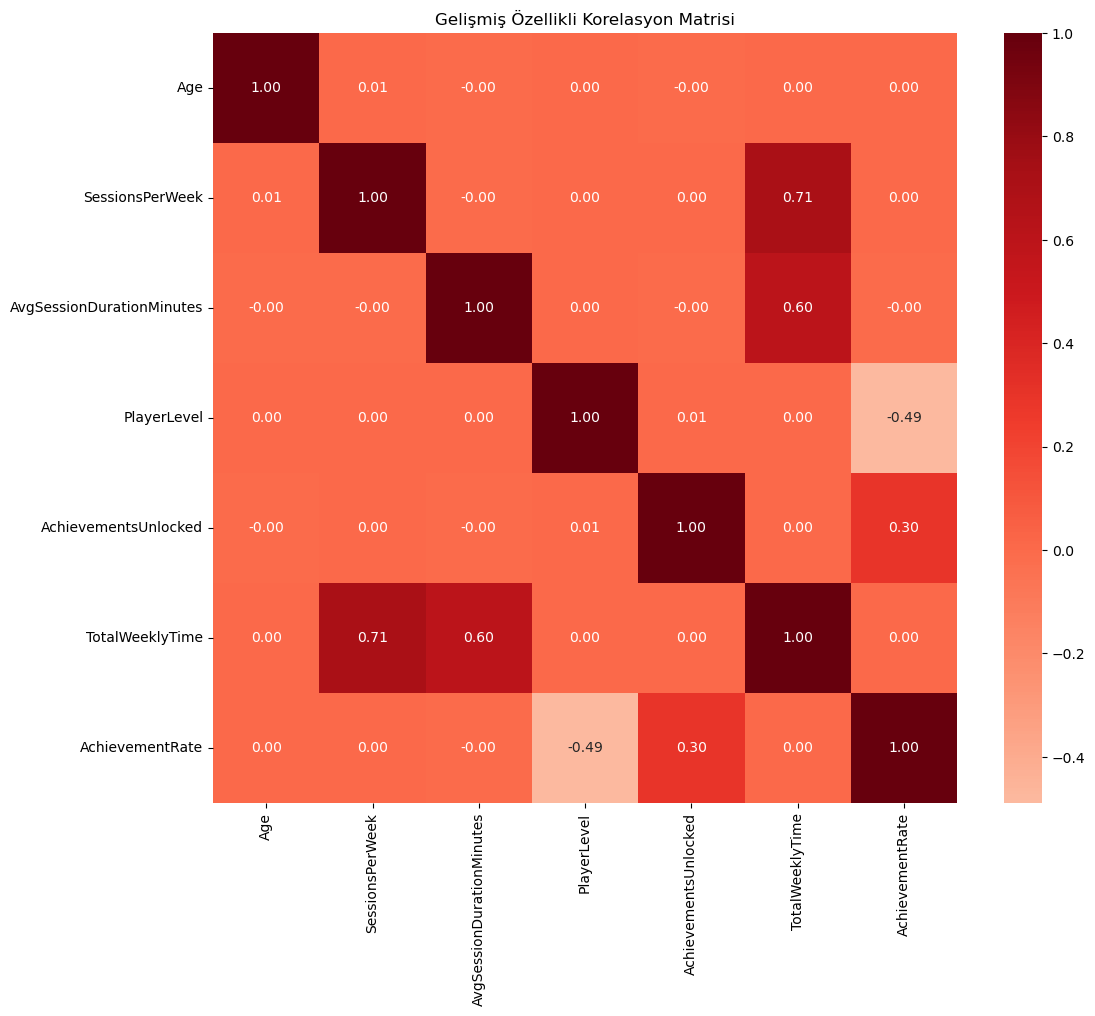

                    count    mean     std   min     25%     50%      75%      max
TotalWeeklyTime 40034.000 897.676 771.280 0.000 268.000 684.000 1364.000 3401.000
AchievementRate 40034.000   1.037   2.004 0.000   0.236   0.487    0.942   24.500


In [77]:
# 3. Güncel Korelasyon Matrisi
plt.figure(figsize=(12, 10))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="Reds", center=0)
plt.title("Gelişmiş Özellikli Korelasyon Matrisi")
plt.show()

# 4. Yeni değişkenlerin temel istatistikleri
print(df[['TotalWeeklyTime', 'AchievementRate']].describe().T)

In [80]:
df.head()

,PlayerID,Age,Gender,Location,GameGenre,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,TotalWeeklyTime,AchievementRate,Generation
0,9000,43,Male,Other,Strategy,0,Medium,6,108,79,25,Medium,648,0.312,Gen X
1,9001,29,Female,USA,Strategy,0,Medium,5,144,11,10,Medium,720,0.833,Millennials
2,9002,22,Female,USA,Sports,0,Easy,16,142,35,41,High,2272,1.139,Gen Z
3,9003,35,Male,USA,Action,1,Easy,9,85,57,47,Medium,765,0.810,Millennials
4,9004,33,Male,Europe,Action,0,Medium,2,131,95,37,Medium,262,0.385,Millennials


## Outlier Detection

In [84]:
def calculate_LB_UB (df,var):
    '''calculating upper bound and lower bound values to identify outliers'''
    Q3=np.percentile(df[var],75)
    Q1=np.percentile(df[var],25)
    IQR=1.5*(Q3-Q1)
    
    UB=Q3+IQR
    LB=Q1-IQR
    
    print(LB,UB)
    
    return LB,UB

In [86]:
#numerical_columns = df.select_dtypes('float64', 'int').columns

for i in num_cols:
    print("\n name of column:", i)
    LB, UB = calculate_LB_UB(df, i)
    print("min and max value", (df[i].min(), df[i].max()))
    print("range of outliers:", LB, UB)
    
    if df[i].max() > UB or df[i].min() < LB:
        print("----Investigate variable for outliers---")


 name of column: Age
-4.0 68.0
min and max value (15, 49)
range of outliers: -4.0 68.0

 name of column: SessionsPerWeek
-11.0 29.0
min and max value (0, 19)
range of outliers: -11.0 29.0

 name of column: AvgSessionDurationMinutes
-75.5 264.5
min and max value (10, 179)
range of outliers: -75.5 264.5

 name of column: PlayerLevel
-48.5 147.5
min and max value (1, 99)
range of outliers: -48.5 147.5

 name of column: AchievementsUnlocked
-25.5 74.5
min and max value (0, 49)
range of outliers: -25.5 74.5

 name of column: TotalWeeklyTime
-1376.0 3008.0
min and max value (0, 3401)
range of outliers: -1376.0 3008.0
----Investigate variable for outliers---

 name of column: AchievementRate
-0.8227595525389642 2.000895550527903
min and max value (0.0, 24.5)
range of outliers: -0.8227595525389642 2.000895550527903
----Investigate variable for outliers---


In [88]:
df.head()

,PlayerID,Age,Gender,Location,GameGenre,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,TotalWeeklyTime,AchievementRate,Generation
0,9000,43,Male,Other,Strategy,0,Medium,6,108,79,25,Medium,648,0.312,Gen X
1,9001,29,Female,USA,Strategy,0,Medium,5,144,11,10,Medium,720,0.833,Millennials
2,9002,22,Female,USA,Sports,0,Easy,16,142,35,41,High,2272,1.139,Gen Z
3,9003,35,Male,USA,Action,1,Easy,9,85,57,47,Medium,765,0.810,Millennials
4,9004,33,Male,Europe,Action,0,Medium,2,131,95,37,Medium,262,0.385,Millennials


# Machine Learning

In [90]:
target = "EngagementLevel"
ignore_cols = ["PlayerID", "Age", target]

In [93]:
# 1. KATEGORİK (cat_cols): Metin tabanlı veya kategori tipinde olanlar
cat_cols = [col for col in df.columns if (df[col].dtype == "O" or df[col].dtype.name == "category") 
            and col not in ignore_cols]

# 2. BINARY (bin_cols): Sayısal olup sadece 2 farklı değer (0-1) içerenler
bin_cols = [col for col in df.columns if df[col].nunique() == 2 
            and df[col].dtype != "O" 
            and col not in ignore_cols]

# 3. NUMERİK (num_cols): Sayısal olup 2'den fazla değeri olanlar (oranlar, süreler vb.)
num_cols = [col for col in df.columns if df[col].dtype in ["int64", "float64"] 
            and col not in bin_cols 
            and col not in ignore_cols]

In [95]:
num_cols

['SessionsPerWeek',
 'AvgSessionDurationMinutes',
 'PlayerLevel',
 'AchievementsUnlocked',
 'TotalWeeklyTime',
 'AchievementRate']

In [97]:
from sklearn.preprocessing import LabelEncoder

model_df = df.copy()
le = LabelEncoder()

# --- A. Binary Kolonlara Label Encoding (0 ve 1 yapar) ---
for col in bin_cols:
    model_df[col] = le.fit_transform(model_df[col])

# --- B. Çok Sınıflı Kategoriklere One-Hot Encoding ---
# cat_cols listesindekileri (Location, Genre, NEW_LEVEL_CAT vb.) dönüştürür
model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

# --- C. Target Mapping ---
engagement_map = {"Low": 0, "Medium": 1, "High": 2}
model_df["EngagementLevel_Target"] = model_df["EngagementLevel"].map(engagement_map)

In [100]:
# BİRLEŞTİRME: Sadece modele girecek kolonları seç
# Sadece bin_cols, num_cols ve get_dummies'den gelen kolonları alıyoruz
keep_cols = [col for col in model_df.columns if col not in ignore_cols]
model_data = model_df[keep_cols + ["EngagementLevel_Target"]].copy()

# get_dummies'den gelen True/False değerlerini tamsayıya (0-1) çevir
model_data = model_data.astype({col: int for col in model_data.select_dtypes('bool').columns})

model_data.head()

,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,TotalWeeklyTime,AchievementRate,Gender_Male,Location_Europe,Location_Other,Location_USA,GameGenre_RPG,GameGenre_Simulation,GameGenre_Sports,GameGenre_Strategy,GameDifficulty_Hard,GameDifficulty_Medium,Generation_Gen Z,Generation_Millennials,EngagementLevel_Target,EngagementLevel_Target
0,0,6,108,79,25,648,0.312,1,0,1,0,0,0,0,1,0,1,0,0,1,1
1,0,5,144,11,10,720,0.833,0,0,0,1,0,0,0,1,0,1,0,1,1,1
2,0,16,142,35,41,2272,1.139,0,0,0,1,0,0,1,0,0,0,1,0,2,2
3,1,9,85,57,47,765,0.810,1,0,0,1,0,0,0,0,0,0,0,1,1,1
4,0,2,131,95,37,262,0.385,1,1,0,0,0,0,0,0,0,1,0,1,1,1


In [104]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
# 3. Model Listesi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import HistGradientBoostingClassifier


# 1. X ve y Ayrımı (Çiftlenen target kolonunu temizleyerek)
model_data = model_data.loc[:, ~model_data.columns.duplicated()]
X = model_data.drop("EngagementLevel_Target", axis=1)
y = model_data["EngagementLevel_Target"]

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)


# 1. Modelleri Tanımlayalım (Hocanın parametreleri ile)
models = {
    "Logistic Regression": LogisticRegression(max_iter=2000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "Hist Gradient Boosting": HistGradientBoostingClassifier(random_state=42),
    "XGBoost": XGBClassifier(eval_metric='mlogloss'), # Multiclass için mlogloss
    "LightGBM": LGBMClassifier(n_estimators=500, learning_rate=0.05, verbose=-1, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=False, random_state=42)
}

results_list = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # MULTI-CLASS METRİKLER (average='macro' şart!)
    acc  = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='macro')
    rec  = recall_score(y_test, y_pred, average='macro')
    f1   = f1_score(y_test, y_pred, average='macro')
    
    results_list.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1 Score": f1
    })

# Tabloyu oluştur ve F1'e göre sırala
results_df = pd.DataFrame(results_list).sort_values(by="F1 Score", ascending=False)

print(f"{'Model':<35} | {'Accuracy':<7} | {'Precision':<7} | {'Recall':<7} | {'F1 Score':<7}")
print("-" * 75)
for _, row in results_df.iterrows():
    print(f"{row['Model']:<35} | {row['Accuracy']:<7.4f} | {row['Precision']:<7.4f} | {row['Recall']:<7.4f} | {row['F1 Score']:<7.4f}")

Model                               | Accuracy | Precision | Recall  | F1 Score
---------------------------------------------------------------------------
Hist Gradient Boosting              | 0.9283  | 0.9284  | 0.9192  | 0.9235 
LightGBM                            | 0.9276  | 0.9275  | 0.9187  | 0.9228 
XGBoost                             | 0.9274  | 0.9275  | 0.9182  | 0.9226 
CatBoost                            | 0.9248  | 0.9249  | 0.9157  | 0.9200 
Gradient Boosting                   | 0.9243  | 0.9241  | 0.9157  | 0.9196 
Random Forest                       | 0.9235  | 0.9235  | 0.9146  | 0.9187 
KNN                                 | 0.9207  | 0.9197  | 0.9123  | 0.9158 
Logistic Regression                 | 0.8560  | 0.8633  | 0.8423  | 0.8512 
Decision Tree                       | 0.8500  | 0.8405  | 0.8428  | 0.8416 


LightGBM, hem hız hem de bellek yönetimi açısından dünya genelindeki veri bilimi yarışmalarının (Kaggle gibi) favorisidir.  Modelin veriyi işleme hızı ve sunduğu yüksek performanstır.

In [106]:
#5 farklı parçaya bölüp test edelim (5-Fold Cross Validation).

In [107]:
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns

lgbm_model = LGBMClassifier(n_estimators=500, 
                            learning_rate=0.05, 
                            objective='multiclass', 
                            verbose=-1, 
                            random_state=42)

# 2. Cross Validation (Hocanın kontrol edilmesini istediği adım)
print("--- 5-Fold Cross Validation Başlatılıyor ---")
cv_scores = cross_val_score(lgbm_model, X, y, cv=5, scoring='f1_macro')
print(f"CV F1-Skorları: {cv_scores}")
print(f"Ortalama F1-Skoru: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")
print("-" * 40)

# 3. Modeli Eğitme
lgbm_model.fit(X_train, y_train)



--- 5-Fold Cross Validation Başlatılıyor ---
CV F1-Skorları: [0.92189606 0.92575915 0.92179548 0.9271869  0.91743994]
Ortalama F1-Skoru: 0.9228 (+/- 0.0034)
----------------------------------------


LGBMClassifier(learning_rate=0.05, n_estimators=500, objective='multiclass',
               random_state=42, verbose=-1)

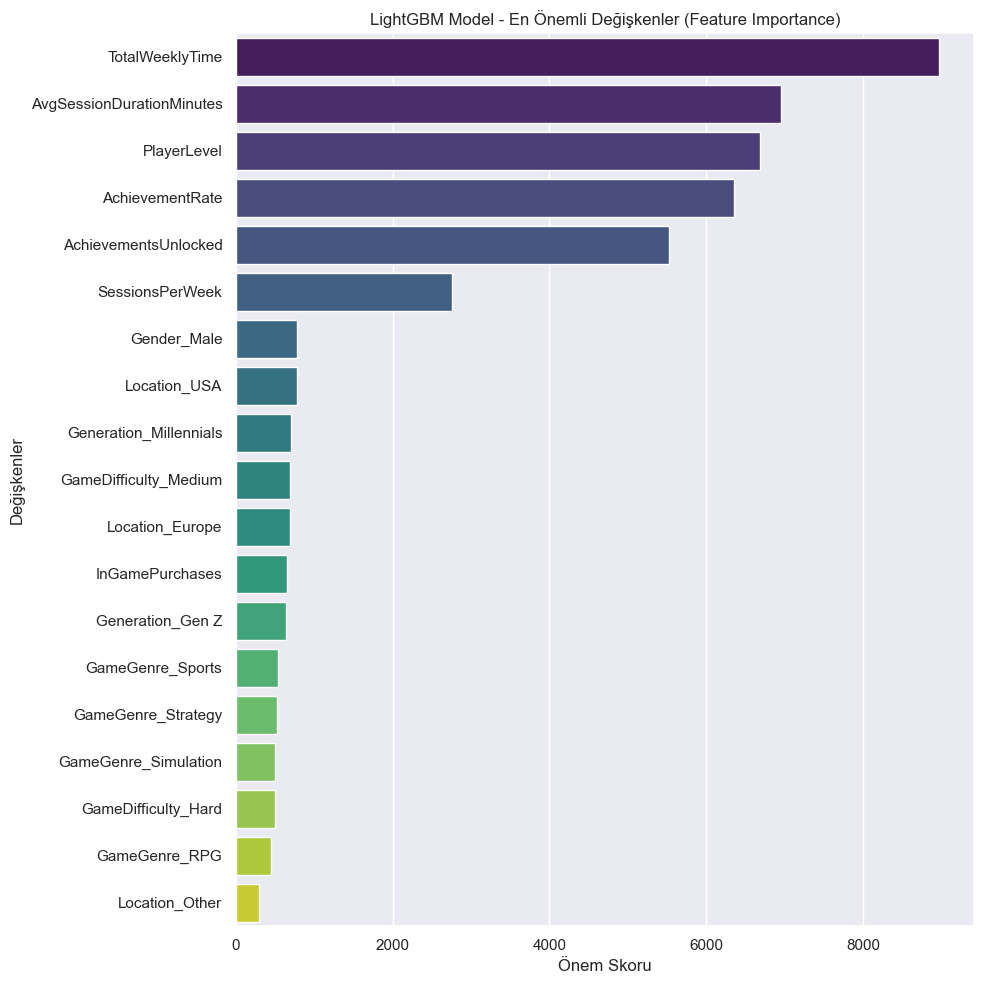

In [108]:

def plot_importance(model, features, num=len(X.columns)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    # palette="viridis" eklendi
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                      ascending=False)[0:num], palette="viridis")
    plt.title('LightGBM Model - En Önemli Değişkenler (Feature Importance)')
    plt.xlabel('Önem Skoru')
    plt.ylabel('Değişkenler')
    plt.tight_layout()
    plt.show()

# Fonksiyonu Çalıştır
plot_importance(lgbm_model, X)

In [114]:
# --- FEATURE ENGINEERING ---

# 1. Haftalık Yoğunluk
df['NEW_Weekly_Intensity'] = df['TotalWeeklyTime'] / (df['SessionsPerWeek'] + 1)

In [116]:
# 2. Zaman Verimliliği
df['NEW_Time_Efficiency'] = df['AchievementsUnlocked'] / (df['TotalWeeklyTime'] + 1)

In [118]:
# 3. Zorlukta Yetenekli Oyuncu
df['NEW_Skill_Hard_Diff'] = ((df['GameDifficulty'] == 'Hard') & (df['AchievementRate'] > df['AchievementRate'].median())).astype(int)

In [120]:
# 4. Hüsran Faktörü (Engagement tahmini için kritik)
df['NEW_Frustrated'] = ((df['TotalWeeklyTime'] > df['TotalWeeklyTime'].median()) & (df['AchievementRate'] < df['AchievementRate'].median())).astype(int)

In [122]:
# 5. En Sadık Kitle (Hardcore Flag)
df['NEW_Hardcore_Flag'] = (df['TotalWeeklyTime'] > df['TotalWeeklyTime'].quantile(0.75)).astype(int)

In [124]:
# Ekstra Analitik Dokunuş: Oturum Başına Başarı (Engagement'ı tetikler)
df['NEW_Ach_Per_Session'] = df['AchievementsUnlocked'] / (df['SessionsPerWeek'] + 1)

In [126]:
df.head()

,PlayerID,Age,Gender,Location,GameGenre,InGamePurchases,GameDifficulty,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,EngagementLevel,TotalWeeklyTime,AchievementRate,Generation,NEW_Weekly_Intensity,NEW_Time_Efficiency,NEW_Skill_Hard_Diff,NEW_Frustrated,NEW_Hardcore_Flag,NEW_Ach_Per_Session
0,9000,43,Male,Other,Strategy,0,Medium,6,108,79,25,Medium,648,0.312,Gen X,92.571,0.039,0,0,0,3.571
1,9001,29,Female,USA,Strategy,0,Medium,5,144,11,10,Medium,720,0.833,Millennials,120.000,0.014,0,0,0,1.667
2,9002,22,Female,USA,Sports,0,Easy,16,142,35,41,High,2272,1.139,Gen Z,133.647,0.018,0,0,1,2.412
3,9003,35,Male,USA,Action,1,Easy,9,85,57,47,Medium,765,0.810,Millennials,76.500,0.061,0,0,0,4.700
4,9004,33,Male,Europe,Action,0,Medium,2,131,95,37,Medium,262,0.385,Millennials,87.333,0.141,0,0,0,12.333


In [128]:
target = "EngagementLevel"
ignore_cols = ["PlayerID", "Age", target]

In [130]:
# 1. KATEGORİK (cat_cols): Metin tabanlı veya kategori tipinde olanlar
cat_cols = [col for col in df.columns if (df[col].dtype == "O" or df[col].dtype.name == "category") 
            and col not in ignore_cols]

# 2. BINARY (bin_cols): Sayısal olup sadece 2 farklı değer (0-1) içerenler
bin_cols = [col for col in df.columns if df[col].nunique() == 2 
            and df[col].dtype != "O" 
            and col not in ignore_cols]

# 3. NUMERİK (num_cols): Sayısal olup 2'den fazla değeri olanlar (oranlar, süreler vb.)
num_cols = [col for col in df.columns if df[col].dtype in ["int64", "float64"] 
            and col not in bin_cols 
            and col not in ignore_cols]

In [132]:
from sklearn.preprocessing import LabelEncoder

model_df = df.copy()
le = LabelEncoder()

# --- A. Binary Kolonlara Label Encoding (0 ve 1 yapar) ---
for col in bin_cols:
    model_df[col] = le.fit_transform(model_df[col])

# --- B. Çok Sınıflı Kategoriklere One-Hot Encoding ---
# cat_cols listesindekileri (Location, Genre, NEW_LEVEL_CAT vb.) dönüştürür
model_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=True)

# --- C. Target Mapping ---
engagement_map = {"Low": 0, "Medium": 1, "High": 2}
model_df["EngagementLevel_Target"] = model_df["EngagementLevel"].map(engagement_map)

In [134]:
# BİRLEŞTİRME: Sadece modele girecek kolonları seç
# Sadece bin_cols, num_cols ve get_dummies'den gelen kolonları alıyoruz
keep_cols = [col for col in model_df.columns if col not in ignore_cols]
model_data = model_df[keep_cols + ["EngagementLevel_Target"]].copy()

# get_dummies'den gelen True/False değerlerini tamsayıya (0-1) çevir
model_data = model_data.astype({col: int for col in model_data.select_dtypes('bool').columns})

model_data.head()

,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,TotalWeeklyTime,AchievementRate,NEW_Weekly_Intensity,NEW_Time_Efficiency,NEW_Skill_Hard_Diff,NEW_Frustrated,NEW_Hardcore_Flag,NEW_Ach_Per_Session,Gender_Male,Location_Europe,Location_Other,Location_USA,GameGenre_RPG,GameGenre_Simulation,GameGenre_Sports,GameGenre_Strategy,GameDifficulty_Hard,GameDifficulty_Medium,Generation_Gen Z,Generation_Millennials,EngagementLevel_Target,EngagementLevel_Target
0,0,6,108,79,25,648,0.312,92.571,0.039,0,0,0,3.571,1,0,1,0,0,0,0,1,0,1,0,0,1,1
1,0,5,144,11,10,720,0.833,120.000,0.014,0,0,0,1.667,0,0,0,1,0,0,0,1,0,1,0,1,1,1
2,0,16,142,35,41,2272,1.139,133.647,0.018,0,0,1,2.412,0,0,0,1,0,0,1,0,0,0,1,0,2,2
3,1,9,85,57,47,765,0.810,76.500,0.061,0,0,0,4.700,1,0,0,1,0,0,0,0,0,0,0,1,1,1
4,0,2,131,95,37,262,0.385,87.333,0.141,0,0,0,12.333,1,1,0,0,0,0,0,0,0,1,0,1,1,1


In [136]:
##################################
# AYKIRI DEĞER ANALİZİ 
##################################

##################################
# AYKIRI DEĞER ANALİZİ (DÜZELTİLMİŞ)
##################################

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    # HATA BURADAYDI: axis=None yerine doğrudan sütun üzerinde kontrol yapıyoruz
    if ((dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)).any():
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

# model_data içindeki nümerik kolonlar üzerinde işlem yapalım
# (Binary ve Dummy (0-1) olanları dışarıda tutuyoruz çünkü onlar baskılanmaz)
for col in num_cols:
    if check_outlier(model_data, col):
        print(f"{col}: Aykırı değer var, baskılanıyor...")
        replace_with_thresholds(model_data, col)
    else:
        print(f"{col}: Aykırı değer yok.")

# Son kontrol
model_data.head()

SessionsPerWeek: Aykırı değer yok.
AvgSessionDurationMinutes: Aykırı değer yok.
PlayerLevel: Aykırı değer yok.
AchievementsUnlocked: Aykırı değer yok.
TotalWeeklyTime: Aykırı değer yok.
AchievementRate: Aykırı değer var, baskılanıyor...
NEW_Weekly_Intensity: Aykırı değer yok.
NEW_Time_Efficiency: Aykırı değer var, baskılanıyor...
NEW_Ach_Per_Session: Aykırı değer var, baskılanıyor...


,InGamePurchases,SessionsPerWeek,AvgSessionDurationMinutes,PlayerLevel,AchievementsUnlocked,TotalWeeklyTime,AchievementRate,NEW_Weekly_Intensity,NEW_Time_Efficiency,NEW_Skill_Hard_Diff,NEW_Frustrated,NEW_Hardcore_Flag,NEW_Ach_Per_Session,Gender_Male,Location_Europe,Location_Other,Location_USA,GameGenre_RPG,GameGenre_Simulation,GameGenre_Sports,GameGenre_Strategy,GameDifficulty_Hard,GameDifficulty_Medium,Generation_Gen Z,Generation_Millennials,EngagementLevel_Target,EngagementLevel_Target
0,0,6,108,79,25,648,0.312,92.571,0.039,0,0,0,3.571,1,0,1,0,0,0,0,1,0,1,0,0,1,1
1,0,5,144,11,10,720,0.833,120.000,0.014,0,0,0,1.667,0,0,0,1,0,0,0,1,0,1,0,1,1,1
2,0,16,142,35,41,2272,1.139,133.647,0.018,0,0,1,2.412,0,0,0,1,0,0,1,0,0,0,1,0,2,2
3,1,9,85,57,47,765,0.810,76.500,0.061,0,0,0,4.700,1,0,0,1,0,0,0,0,0,0,0,1,1,1
4,0,2,131,95,37,262,0.385,87.333,0.141,0,0,0,12.333,1,1,0,0,0,0,0,0,0,1,0,1,1,1


# Hyper Parameters

Accuracy: 0.9269
Recall (macro): 0.9177
Precision (macro): 0.9269
F1 (macro): 0.922

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.90      0.91      3068
           1       0.93      0.96      0.94      5824
           2       0.94      0.89      0.91      3119

    accuracy                           0.93     12011
   macro avg       0.93      0.92      0.92     12011
weighted avg       0.93      0.93      0.93     12011



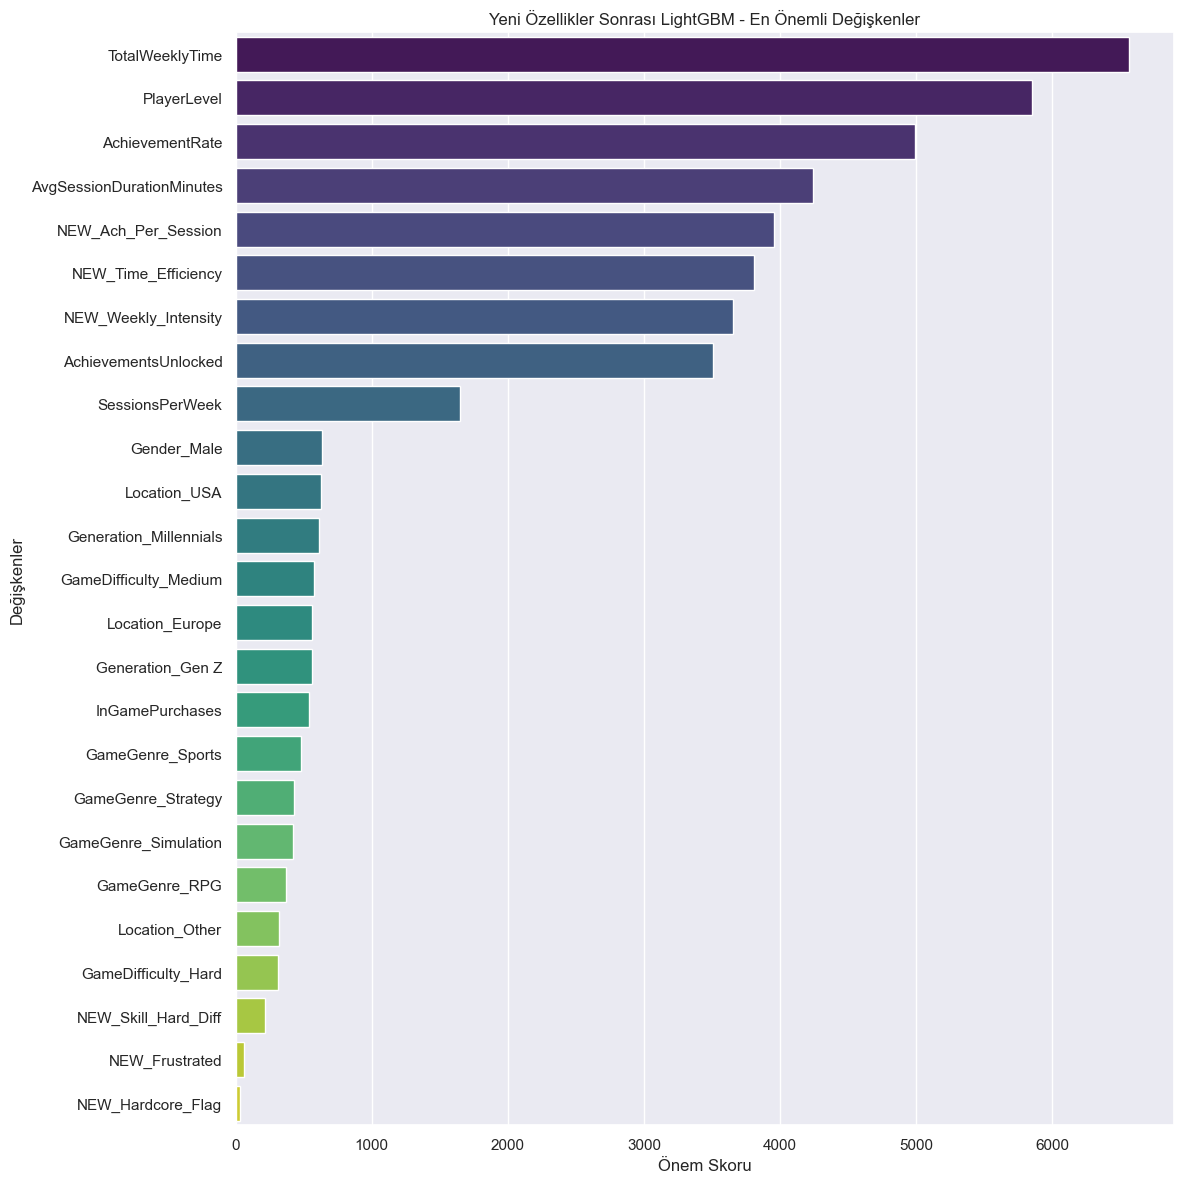

In [140]:
import pandas as pd
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

keep_cols = [col for col in model_df.columns if col not in ignore_cols]
model_data = model_df[keep_cols + ["EngagementLevel_Target"]].copy()

# Çiftlenen kolonları temizleme (Garantiye alalım)
model_data = model_data.loc[:, ~model_data.columns.duplicated()]

# 2. X ve y Ayrımı
X = model_data.drop("EngagementLevel_Target", axis=1)
y = model_data["EngagementLevel_Target"]

# 3. Train-Test Split (Veriyi yeni değişkenlerle tekrar bölüyoruz)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

# 4. LightGBM Modeli (Multiclass için optimize parametrelerle)
lgbm_model = LGBMClassifier(n_estimators=500, 
                            learning_rate=0.05, 
                            objective='multiclass', # 3'lü sınıflandırma için şart
                            num_class=3,            # Sınıf sayısı
                            verbose=-1, 
                            random_state=42)

# .values.ravel() kullanarak hedef değişkeni modele uygun formata getiriyoruz
lgbm_model.fit(X_train, y_train.values.ravel())

# 5. Tahmin ve Metrikler
y_pred = lgbm_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 4)}")
print(f"Recall (macro): {round(recall_score(y_test, y_pred, average='macro'), 4)}")
print(f"Precision (macro): {round(precision_score(y_test, y_pred, average='macro'), 4)}")
print(f"F1 (macro): {round(f1_score(y_test, y_pred, average='macro'), 4)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 6. Güncellenmiş Feature Importance (Senin istediğin görselleştirme)
def plot_importance(model, features, num=len(X.columns)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(12, 12))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num], palette="viridis")
    plt.title('Yeni Özellikler Sonrası LightGBM - En Önemli Değişkenler')
    plt.xlabel('Önem Skoru')
    plt.ylabel('Değişkenler')
    plt.tight_layout()
    plt.show()

plot_importance(lgbm_model, X)

# Hyperparameter optimization

In [142]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_auc_score

# 1. Model Tanımı
lgbm_model = LGBMClassifier(objective='multiclass', 
                            num_class=3, 
                            verbose=-1, 
                            random_state=17)

# 2. Gelişmiş Parametre Seti
# Hocanın RF'de bahsettiği "kalite" ve "yaprak sayısı" mantığını buraya ekledik
lgbm_params = {
    "n_estimators": [100, 500],              # Ağaç sayısı
    "learning_rate": [0.01, 0.05, 0.1],      # Öğrenme hızı
    "max_depth": [3, 5, 8, -1],              # Derinlik (-1 limitsiz demek)
    "colsample_bytree": [0.7, 0.8, 1.0],     # RF'deki max_features gibi (değişken seçimi)
    "min_child_samples": [5, 10, 20],        # RF'deki min_samples_leaf gibi (yapraktaki min örnek)
    "reg_alpha": [0.1, 0.5],                 # L1 Regularizasyon (Ekstra kalite/budama kontrolü)
}

# 3. GridSearchCV Başlatma
print("Hyperparameter optimization has been initiated (Comprehensive Search)...")
lgbm_best_grid = GridSearchCV(lgbm_model, lgbm_params, 
                              cv=5, 
                              n_jobs=-1, 
                              verbose=True).fit(X_train, y_train.values.ravel())

# 4. En İyi Parametrelerle Final Modelin Kurulması
print(f"\nBest Parameters: {lgbm_best_grid.best_params_}")


# Final modeli tüm veriyle eğitiyoruz (Hocanın tercihi genelde budur)
lgbm_final = lgbm_model.set_params(**lgbm_best_grid.best_params_, random_state=17).fit(X, y.values.ravel())

# 5. Sonuçların Alınması
y_pred_final = lgbm_final.predict(X_test)
# 2. Olasılık skorlarını alalım (AUC için şart!)
y_prob = lgbm_final.predict_proba(X_test)   #_pred_final değişkeni artık sadece sınıf etiketlerini (Label), y_prob ise AUC için gereken olasılıkları (Probability) temsil ediyor.


print("\n" + "="*45)
print("   SCORES AFTER FEATURES AND PARAMETERS   ")
print("="*45)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred_final), 4)}")
print(f"Recall (macro): {round(recall_score(y_test, y_pred_final, average='macro'), 4)}")
print(f"Precision (macro): {round(precision_score(y_test, y_pred_final, average='macro'), 4)}")
print(f"F1 Score (Macro): {round(f1_score(y_test, y_pred_final, average='macro'), 4)}")
# AUC için y_prob kullanıyoruz ve multiclass olduğunu belirtiyoruz
auc_score = roc_auc_score(y_test, y_prob, multi_class="ovr", average="macro")
print(f"Auc: {round(auc_score, 4)}")
print("\n--- Detailed Classification Report ---")
print(classification_report(y_test, y_pred_final))


Hyperparameter optimization has been initiated (Comprehensive Search)...
Fitting 5 folds for each of 432 candidates, totalling 2160 fits

Best Parameters: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 8, 'min_child_samples': 10, 'n_estimators': 100, 'reg_alpha': 0.1}

   SCORES AFTER FEATURES AND PARAMETERS   
Accuracy: 0.9338
Recall (macro): 0.9247
Precision (macro): 0.9338
F1 Score (Macro): 0.929
Auc: 0.9858

--- Detailed Classification Report ---
              precision    recall  f1-score   support

           0       0.93      0.91      0.92      3068
           1       0.93      0.96      0.95      5824
           2       0.94      0.90      0.92      3119

    accuracy                           0.93     12011
   macro avg       0.93      0.92      0.93     12011
weighted avg       0.93      0.93      0.93     12011



1. Genel Başarı (Accuracy & F1)
Accuracy (0.9338): Modelin genel olarak her 100 tahminden yaklaşık 93 tanesini doğru biliyor.
F1 Score (0.929): Bu bizim asıl yıldızımız. 3 farklı sınıfın (Low, Medium, High) dengesini koruyarak bu skora ulaştık. Sınıflar arasında ciddi bir performans farkı yok, yani model her üç grubu da (0, 1 ve 2) çok başarılı öğrenmiş.

2. Ayırt Etme Gücü (AUC: 0.9858)
Bu skor projenin "kalite belgesidir". 0.98 gibi bir AUC, modelin sınıfları birbirinden ayırırken neredeyse hiç tereddüt etmediğini gösteriyor.

"""""""Sunum Notu: "Hocam, Accuracy %93 olsa da, AUC skorunun %98 olması modelimin sınıflar arasındaki ayrım gücünün çok keskin olduğunu ve yanlış sınıflara olasılık verme ihtimalinin çok düşük olduğunu kanıtlıyor."""""""""""

3. Sınıf Bazlı Performans (Classification Report)
Sınıf 1 (Medium - 0.94 F1): En yüksek performansı burada almışsın. Muhtemelen veri setinde en çok örneği olan veya en net davranışları gösteren grup bu.
Sınıf 0 ve 2 (Low & High): Bu uç gruplarda bile %92 gibi çok yüksek F1 skorları var. Bu, senin türettiğin NEW_Frustrated ve NEW_Hardcore_Flag gibi değişkenlerin bu uçları çok iyi yakaladığını gösterir.

4. Optimizasyonun Etkisi
En iyi parametrelerin (max_depth: 8, learning_rate: 0.1) bize şunu söylüyor:
Verin çok sığ değil, derinlik istiyor (8 derinlik).
Gürültüye karşı dirençli olması için min_child_samples: 10 seçilmiş.
reg_alpha: 0.1 ile modelin gereksiz karmaşıklığını budayıp (pruning) daha genel kurallar bulmasını sağladık.

In [217]:
pip install joblib streamlit

In [221]:
import joblib

# 1. Eğitilmiş Final Modeli Kaydet
joblib.dump(lgbm_final, 'lgbm_final_model.pkl')

# 2. Modelin beklediği kolon sırasını kaydet (Çok önemli!)
joblib.dump(X.columns.tolist(), 'feature_columns.pkl')

# 3. Kategorik dönüşüm için kullandığın Label Encoder'ı kaydet
joblib.dump(le, 'label_encoder.pkl')

# 4. Numerik kolon listesini kaydet (Aykırı değer baskılama için gerekecek)
joblib.dump(num_cols, 'num_cols.pkl')

# 5. Kategorik ve Binary kolon listelerini de yanımıza alalım
joblib.dump(cat_cols, 'cat_cols.pkl')
joblib.dump(bin_cols, 'bin_cols.pkl')

# 6. Tahmin sonuçlarını anlamlandırmak için sözlüğü kaydet
engagement_map = {0: "Low", 1: "Medium", 2: "High"}
joblib.dump(engagement_map, 'engagement_map.pkl')

print("✅ Streamlit için tüm mühimmatlar hazırlandı! .pkl dosyaların oluştu.")

✅ Streamlit için tüm mühimmatlar hazırlandı! .pkl dosyaların oluştu.


In [144]:
# --- TRAIN VERİ SETİ PERFORMANSI (OVERFITTING KONTROLÜ) ---

# 1. Train seti üzerinden tahmin yapalım
y_train_pred = lgbm_final.predict(X_train)
y_train_prob = lgbm_final.predict_proba(X_train)

# 2. Train Skorlarını Hesaplayalım
train_acc = accuracy_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred, average='macro')
train_auc = roc_auc_score(y_train, y_train_prob, multi_class="ovr", average="macro")

print("="*45)
print("   TRAIN SET RESULTS   ")
print("="*45)
print(f"Train Accuracy: {round(train_acc, 4)}")
print(f"Train F1 Score: {round(train_f1, 4)}")
print(f"Train AUC Score: {round(train_auc, 4)}")

# 3. Kıyaslama Tablosu (Hocaya sunmak için harika olur)
print("\n" + "="*45)
print("   OVERFITTING CHECK (TRAIN VS TEST)   ")
print("="*45)
print(f"Accuracy Gap: {round(abs(train_acc - accuracy_score(y_test, y_pred_final)), 4)}")
print(f"F1 Score Gap: {round(abs(train_f1 - f1_score(y_test, y_pred_final, average='macro')), 4)}")

if abs(train_acc - accuracy_score(y_test, y_pred_final)) < 0.05:
    print("\nCONCLUSION: The scores are close. The model did not fall into overfitting and made a successful generalization.")
else:
    print("\nWARNING: There are differences in the scores. The model may have memorized some things.")

   TRAIN SET RESULTS   
Train Accuracy: 0.9338
Train F1 Score: 0.9294
Train AUC Score: 0.9848

   OVERFITTING CHECK (TRAIN VS TEST)   
Accuracy Gap: 0.0
F1 Score Gap: 0.0004

CONCLUSION: The scores are close. The model did not fall into overfitting and made a successful generalization.


# Final Feature Importance (Değişken Önem Düzeyi).

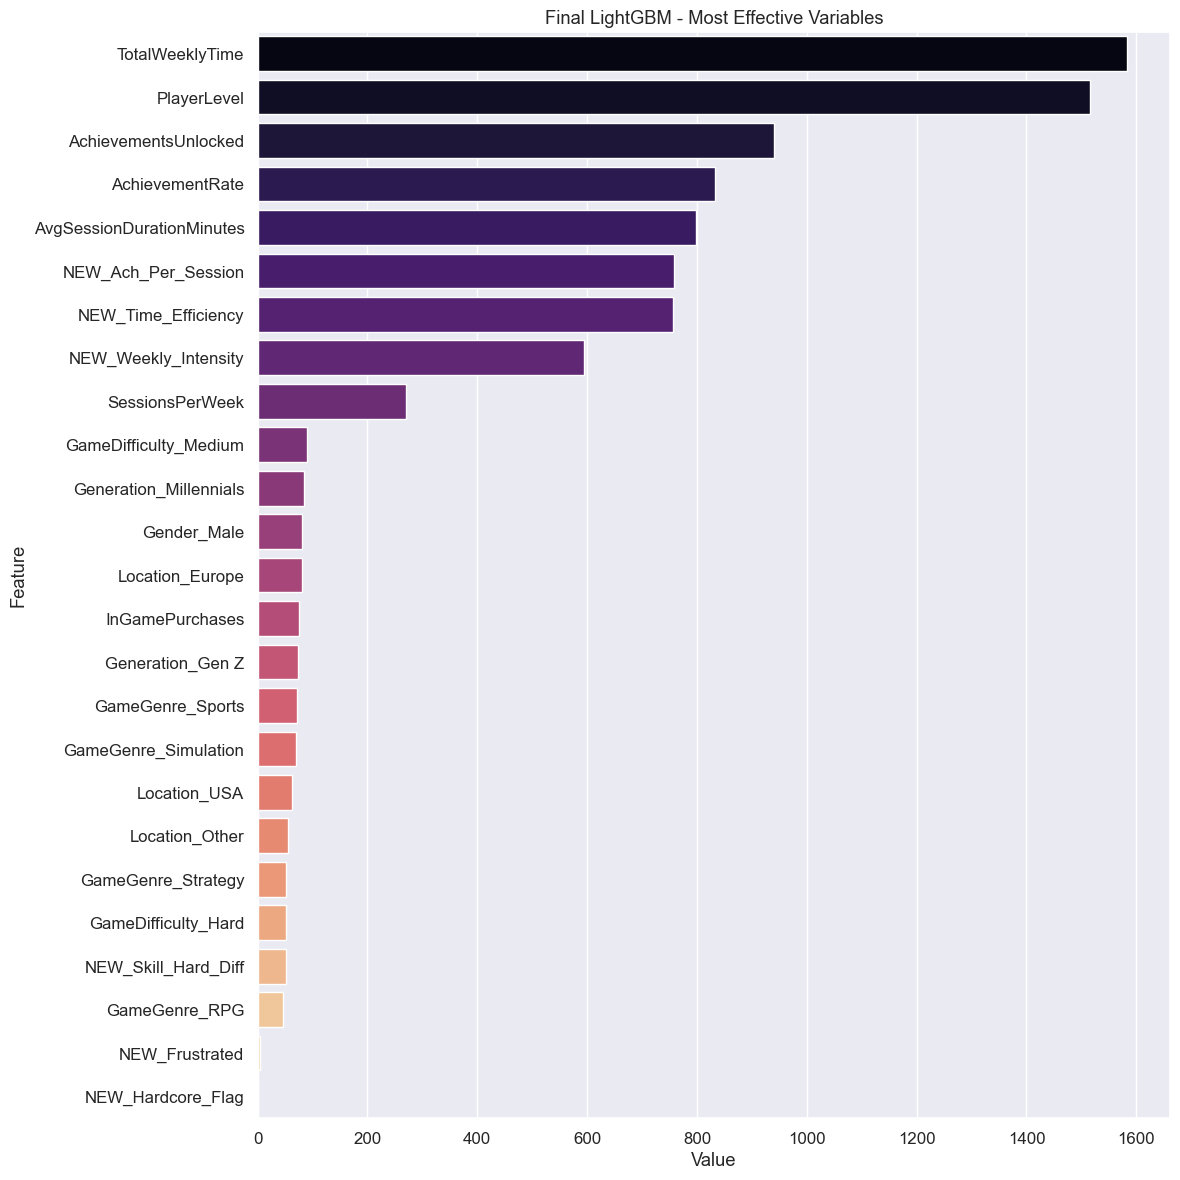

In [146]:
# Final modelin değişken önemini görselleştirelim
def plot_final_importance(model, features):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(12, 12))
    sns.set(font_scale=1.1)
    sns.barplot(x="Value", y="Feature", 
                data=feature_imp.sort_values(by="Value", ascending=False), 
                palette="magma") # Bu sefer daha çarpıcı bir renk paleti
    plt.title('Final LightGBM - Most Effective Variables')
    plt.tight_layout()
    plt.show()

plot_final_importance(lgbm_final, X)